# 03 - Interactive Viz

## Deadline

Wednesday November 8th, 2017 at 11:59PM

## Important Notes

- Make sure you push on GitHub your Notebook with all the cells already evaluated
- Note that maps do not render in a standard Github environment : you should export them to HTML and link them in your notebook.
- Remember that `.csv` is not the only data format. Though they might require additional processing, some formats provide better encoding support.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
- Please write all your comments in English, and use meaningful variable names in your code

## Background

In this homework we will be exploring interactive visualization, which is a key ingredient of many successful data visualizations (especially when it comes to infographics).

Unemployment rates are major economic metrics and a matter of concern for governments around the world. Though its definition may seem straightforward at first glance (usually defined as the number of unemployed people divided by the active population), it can be tricky to define consistently. For example, one must define what exactly unemployed means : looking for a job ? Having declared their unemployment ? Currently without a job ? Should students or recent graduates be included ? We could also wonder what the active population is : everyone in an age category (e.g. `16-64`) ? Anyone interested by finding a job ? Though these questions may seem subtle, they can have a large impact on the interpretation of the results : `3%` unemployment doesn't mean much if we don't know who is included in this percentage. 

In this homework you will be dealing with two different datasets from the statistics offices of the European commission ([eurostat](http://ec.europa.eu/eurostat/data/database)) and the Swiss Confederation ([amstat](https://www.amstat.ch)). They provide a variety of datasets with plenty of information on many different statistics and demographics at their respective scales. Unfortunately, as is often the case is data analysis, these websites are not always straightforward to navigate. They may include a lot of obscure categories, not always be translated into your native language, have strange link structures, … Navigating this complexity is part of a data scientists' job : you will have to use a few tricks to get the right data for this homework.

For the visualization part, install [Folium](https://github.com/python-visualization/folium) (*HINT*: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!). Folium's `README` comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find two `.topojson` files, containing the geo-coordinates of 

- European countries (*liberal definition of EU*) (`topojson/europe.topojson.json`, [source](https://github.com/leakyMirror/map-of-europe))
- Swiss cantons (`topojson/ch-cantons.topojson.json`) 

These will be used as an overlay on the Folium maps.

## Assignment

1. Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

2. Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

3. Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

4. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

 # /!\ PLEASE CONSIDER /!\

## In order to **correctly see the content of this notebook** follow this [**link**](https://nbviewer.jupyter.org/github/Timonzimm/CS-401/blob/master/HW03/Homework%203.ipynb).

In [1]:
import pandas as pd
import json
import folium
import numpy as np
import pysal # to choose how to split intervals into data classes
import matplotlib.pyplot as plt

TOPO_FOLDER = './topojson/'
DATA_FOLDER = './data/'

## Preparation of the datasets

Here we load the topological data as well as the unemployment rates data from EuroStat, we kept only the dataset with respect to active population (and not the one with respect to the total population) simply because data for Switzerland are only available for the former case.

### Europe

In [2]:
# eu data by active population
eu_total_unemployment_rate = pd.read_excel(DATA_FOLDER + 'eu_total_unemployment_rate_active.xls', na_values=':', header=3)
eu_total_unemployment_rate = eu_total_unemployment_rate.filter(regex=("^((?!Unnamed).)*$"))
eu_total_unemployment_rate.rename(columns={"geo\\time": "country"}, inplace=True)
eu_total_unemployment_rate = eu_total_unemployment_rate.iloc[4:36]

eu_topojson = json.load(open(TOPO_FOLDER + 'europe.topojson.json'))

From there, get the most recent year available for each country.

In [3]:
def most_recent_available(row):
    for rate in reversed(row):
        if rate: # if not NaN
            return pd.Series({'country': row['country'], 'rate': rate})

eu_total_unemployment_rate = eu_total_unemployment_rate.apply(most_recent_available, axis=1)

# We will complete the data with the last missing value: Switzerland
# https://www.amstat.ch/seco/pressedoku/201701_Leporello_fr.pdf
eu_total_unemployment_rate.loc[eu_total_unemployment_rate.country == 'Switzerland', 'rate'] = 3.7

### Switzerland

In [4]:
# ch data by active population
ch_total_unemployment_rate = pd.read_excel(DATA_FOLDER + 'ch_total_unemployment_rate_active.xlsx', header=1)
ch_total_unemployment_rate = ch_total_unemployment_rate.reset_index()[['index', 'Taux de chômage']]
ch_total_unemployment_rate.rename(columns={"index": "canton", "Taux de chômage": "rate"}, inplace=True)
ch_total_unemployment_rate = ch_total_unemployment_rate.iloc[:-1]

# ch data by pourcentage by sex
ch_total_unemployment_rate_by_sex = pd.read_excel(DATA_FOLDER + 'ch_total_unemployment_rate_by_sex.xlsx', header=1)
ch_total_unemployment_rate_by_sex = ch_total_unemployment_rate_by_sex.reset_index()[['level_0', 'level_1', 'Taux de chômage']]
ch_total_unemployment_rate_by_sex.rename(columns={"level_0": "canton", "level_1": "sex", "Taux de chômage": "rate"}, inplace=True)
ch_total_unemployment_rate_by_sex = ch_total_unemployment_rate_by_sex.iloc[:-1]
ch_total_unemployment_rate_by_sex = ch_total_unemployment_rate_by_sex.groupby('sex')

ch_total_unemployment_rate["men_rate"] = ch_total_unemployment_rate_by_sex.get_group('Hommes')['rate'].values
ch_total_unemployment_rate["women_rate"] = ch_total_unemployment_rate_by_sex.get_group('Femmes')['rate'].values
ch_total_unemployment_rate["men_women_ratio"] = ch_total_unemployment_rate["men_rate"]/(ch_total_unemployment_rate["men_rate"]+ch_total_unemployment_rate["women_rate"])

# ch data by pourcentage by nationality
ch_total_unemployment_rate_by_nationality = pd.read_excel(DATA_FOLDER + 'ch_total_unemployment_rate_by_nationality.xlsx', header=1)
ch_total_unemployment_rate_by_nationality = ch_total_unemployment_rate_by_nationality.reset_index()[['level_0', 'level_1', 'Taux de chômage']]
ch_total_unemployment_rate_by_nationality.rename(columns={"level_0": "canton", "level_1": "nationality", "Taux de chômage": "rate"}, inplace=True)
ch_total_unemployment_rate_by_nationality = ch_total_unemployment_rate_by_nationality.iloc[:-1]
ch_total_unemployment_rate_by_nationality = ch_total_unemployment_rate_by_nationality.groupby('nationality')

ch_total_unemployment_rate["foreign_rate"] = ch_total_unemployment_rate_by_nationality.get_group('Etrangers')['rate'].values
ch_total_unemployment_rate["domestic_rate"] = ch_total_unemployment_rate_by_nationality.get_group('Suisses')['rate'].values
ch_total_unemployment_rate["foreign_domestic_ratio"] = ch_total_unemployment_rate["foreign_rate"]/(ch_total_unemployment_rate["foreign_rate"]+ch_total_unemployment_rate["domestic_rate"])

# ch data by age group: 15-24, 25-49, 50 and more
ch_total_unemployment_rate_by_ages = pd.read_excel(DATA_FOLDER + 'ch_total_unemployment_rate_by_ages.xlsx', header=3)
ch_total_unemployment_rate_by_ages = ch_total_unemployment_rate_by_ages.reset_index()[['level_0', 'level_1', 'Taux de chômage']]
ch_total_unemployment_rate_by_ages.rename(columns={"level_0": "canton", "level_1": "age_group", "Taux de chômage": "rate"}, inplace=True)
ch_total_unemployment_rate_by_ages = ch_total_unemployment_rate_by_ages.iloc[:-1]
ch_total_unemployment_rate_by_ages = ch_total_unemployment_rate_by_ages.groupby("age_group")

ch_total_unemployment_rate["15_24"] = ch_total_unemployment_rate_by_ages.get_group(1.0)['rate'].values
ch_total_unemployment_rate["25_49"] = ch_total_unemployment_rate_by_ages.get_group(2.0)['rate'].values
ch_total_unemployment_rate["50_"] = ch_total_unemployment_rate_by_ages.get_group(3.0)['rate'].values

ch_topojson = json.load(open(TOPO_FOLDER + 'ch-cantons.topojson.json'))

In [5]:
# Change Switzerland cantons name to code to match with TopoJson, luckily they are in the same order as in the dataframe
for i, row in enumerate(ch_topojson['objects']['cantons']['geometries']):
    ch_total_unemployment_rate.loc[i, 'canton'] = row['id']

In [6]:
# BONUS
french_cantons = ['FR', 'GE', 'VD', 'VS', 'JU', 'NE']
german_cantons = ['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'SO', 'BS', 'BL', 'SH', 'AR', 'AI', 'SG', 'GR', 'AG', 'TG']
italian_cantons = ['TI']

ch_total_unemployment_rate["röstigraben"] = 0

def compute_mean_per_region(parts):
    for part in parts:
        rate = 0
        for canton in part:
            rate += ch_total_unemployment_rate.loc[ch_total_unemployment_rate["canton"] == canton, "rate"].values
        mean = rate/len(part)
        
        for canton in part:
            ch_total_unemployment_rate.loc[ch_total_unemployment_rate["canton"] == canton, "röstigraben"] = mean

compute_mean_per_region([french_cantons, german_cantons, italian_cantons])
ch_total_unemployment_rate.head()

,canton,rate,men_rate,women_rate,men_women_ratio,foreign_rate,domestic_rate,foreign_domestic_ratio,15_24,25_49,50_,röstigraben
0,ZH,3.3,3.3,3.4,0.492537,5.3,2.5,0.679487,3.7,3.4,2.9,2.0
1,BE,2.4,2.4,2.5,0.489796,5.5,1.8,0.753425,2.8,2.5,2.2,2.0
2,LU,1.7,1.8,1.7,0.514286,3.9,1.3,0.750000,2.1,1.7,1.6,2.0
3,UR,0.6,0.5,0.7,0.416667,2.1,0.4,0.840000,0.5,0.5,0.7,2.0
4,SZ,1.7,1.6,1.7,0.484848,3.4,1.2,0.739130,1.6,1.6,1.9,2.0


## Cleaning of TopoJson
Here we only want to keep countries borders for which we have data available.

In [7]:
eu_topojson['objects']['europe']['geometries'] = [row for row in eu_topojson['objects']['europe']['geometries'] 
                                                  if row['properties']['NAME']
                                                  in eu_total_unemployment_rate['country'].values]

## Assumptions

- For the Swiss datasets, we used the unemployment rates from September 2017.


- For the second part of the assignment, it was asked the following:

    *The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.*

    ***Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one.*** *How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.*

    The bolded assignment in the above paragraph suggests that, the author of this question defines the unemployment rate as the people searching for a job that are registered as unemployed, plus the people searching for a job that are not registered as unemployed (i.e., those who already work but want to change their job). But this is not the case actually. The unemployment rate only counts the people searching for a job that are registered as unemployed (which makes sense). Hence, we decided to not provide an extra map with the aggregation of the two types of job seekers defined above, as, for us, this does not provide relevant content.
    The ones left unsatisfied with this way of proceeding will found a Swiss map with the pourcentage of men among unemployed people by canton.


- In the following maps, the natural breaks (Jenks) classification has been used. As a reminder, this classification arranges each classes such that there is less variation within each class.

## European unemployment rate for active population, by country

In [8]:
m = folium.Map([53, 14], tiles='cartodbpositron', zoom_start=4)

bins = pysal.Natural_Breaks(y=eu_total_unemployment_rate['rate'], k=6).bins.tolist()

m.choropleth(
    geo_data=eu_topojson,
    data=eu_total_unemployment_rate,
    columns=['country', 'rate'],
    key_on='feature.properties.NAME',
    topojson='objects.europe',
    threshold_scale=bins,
    fill_color='YlOrRd',
    fill_opacity=0.75,
    line_opacity=1,
    line_weight=1.3,
    legend_name='Unemployment Rate (%)',
    smooth_factor=1.3)

m

We clearly see that the most impacted countries by the unemployment curse are the southern countries, especially  Spain, Greece and Croatia.
We can also notice that northern countries go well in term of unemployment rate.

Although all these countries are part of Europe (one way or another), we see that there is a lot of difference between some countries. Of cource a lot of different factors interact within each country, but they could help each other to reduce the unemployment rate, wether through Brussels or directly between them.

## Swiss unemployment rate for active population, by canton

In [9]:
m = folium.Map([46.918, 8.227], tiles='cartodbpositron', zoom_start=8)

bins = pysal.Natural_Breaks(y=ch_total_unemployment_rate['rate'], k=6).bins.tolist()

m.choropleth(
    geo_data=ch_topojson,
    data=ch_total_unemployment_rate,
    columns=['canton', 'rate'],
    key_on='feature.id',
    topojson='objects.cantons',
    threshold_scale=bins,
    fill_color='YlOrRd',
    fill_opacity=0.75,
    line_opacity=1,
    line_weight=1.3,
    legend_name='Unemployment Rate (%)',
    smooth_factor=1.3)

m

We can clearly notice that western cantons, from the French-speaking part, are the most impacted by the unemployment, with huge rates in Geneva. Jura and Neuchâtel cantons are at the second worst place.

We further notice that rural cantons have a lower unemployment rate than urban cantons.

## Percentage of men among unemployed, by canton

In [10]:
m = folium.Map([46.9182, 8.2275], tiles='cartodbpositron', zoom_start=8)

bins = pysal.Natural_Breaks(y=ch_total_unemployment_rate['men_women_ratio'], k=5).bins.tolist()

m.choropleth(
    geo_data=ch_topojson,
    data=ch_total_unemployment_rate,
    columns=['canton', 'men_women_ratio'],
    key_on='feature.id',
    topojson='objects.cantons',
    threshold_scale=bins,
    fill_color='GnBu',
    fill_opacity=0.75,
    line_opacity=1,
    line_weight=1.3,
    legend_name='Percentage of Men among Unemployed (%)',
    smooth_factor=1.3)

m

First, we see that the variation of the ratio of men and women that are unemployed is relatively small. Indeed, we oscillate between [0.42, 0.54].

Then, we see that there is no clear geographical pattern attached to the different ratios and that they are well mixed among all cantons. One could argue that the distribution is rather random, but we could deepen the research and try to see if there exists a correlation between these ratios and the pourcentage of married people in each canton. In this way, we could see if the number of married couple has a link with the number of men or women that are unemployed for example.

## Percentage of foreigners among unemployed, by canton

In [11]:
m = folium.Map([46.9182, 8.2275], tiles='cartodbpositron', zoom_start=8)

bins = pysal.Natural_Breaks(y=ch_total_unemployment_rate['foreign_domestic_ratio'], k=6).bins.tolist()

m.choropleth(
    geo_data=ch_topojson,
    data=ch_total_unemployment_rate,
    columns=['canton', 'foreign_domestic_ratio'],
    key_on='feature.id',
    topojson='objects.cantons',
    threshold_scale=bins,
    fill_color='BuPu',
    fill_opacity=0.75,
    line_opacity=1,
    line_weight=1.3,
    legend_name='Percentage of Foreigners among Unemployed (%)',
    smooth_factor=1.3)

m

We immediatly notice the highest ratios among Obwald, Grison, Appenzell I. and the three founding cantons of Switzerland, that is: Uri, Schwytz and Nidwald. Uri has the highest disparity among all of them.

Notice that in the extreme eastern cantons, the inequality is less important. Furthermore, in average, German-speaking cantons are more concerned than French-speaking ones.

Analyzing the scale bar, it is interesting to see that there is no canton with a higher pourcentage of Swiss unemployed workers compared to the foreigns of the same category.

These results might be correlated with the pourcentage of foreigns in each cantons. As a further work, it would be interesting to take a dataset with this information and see if, approximately, the same cantons are highlithed.

## Swiss unemployment rate for different age groups, by canton

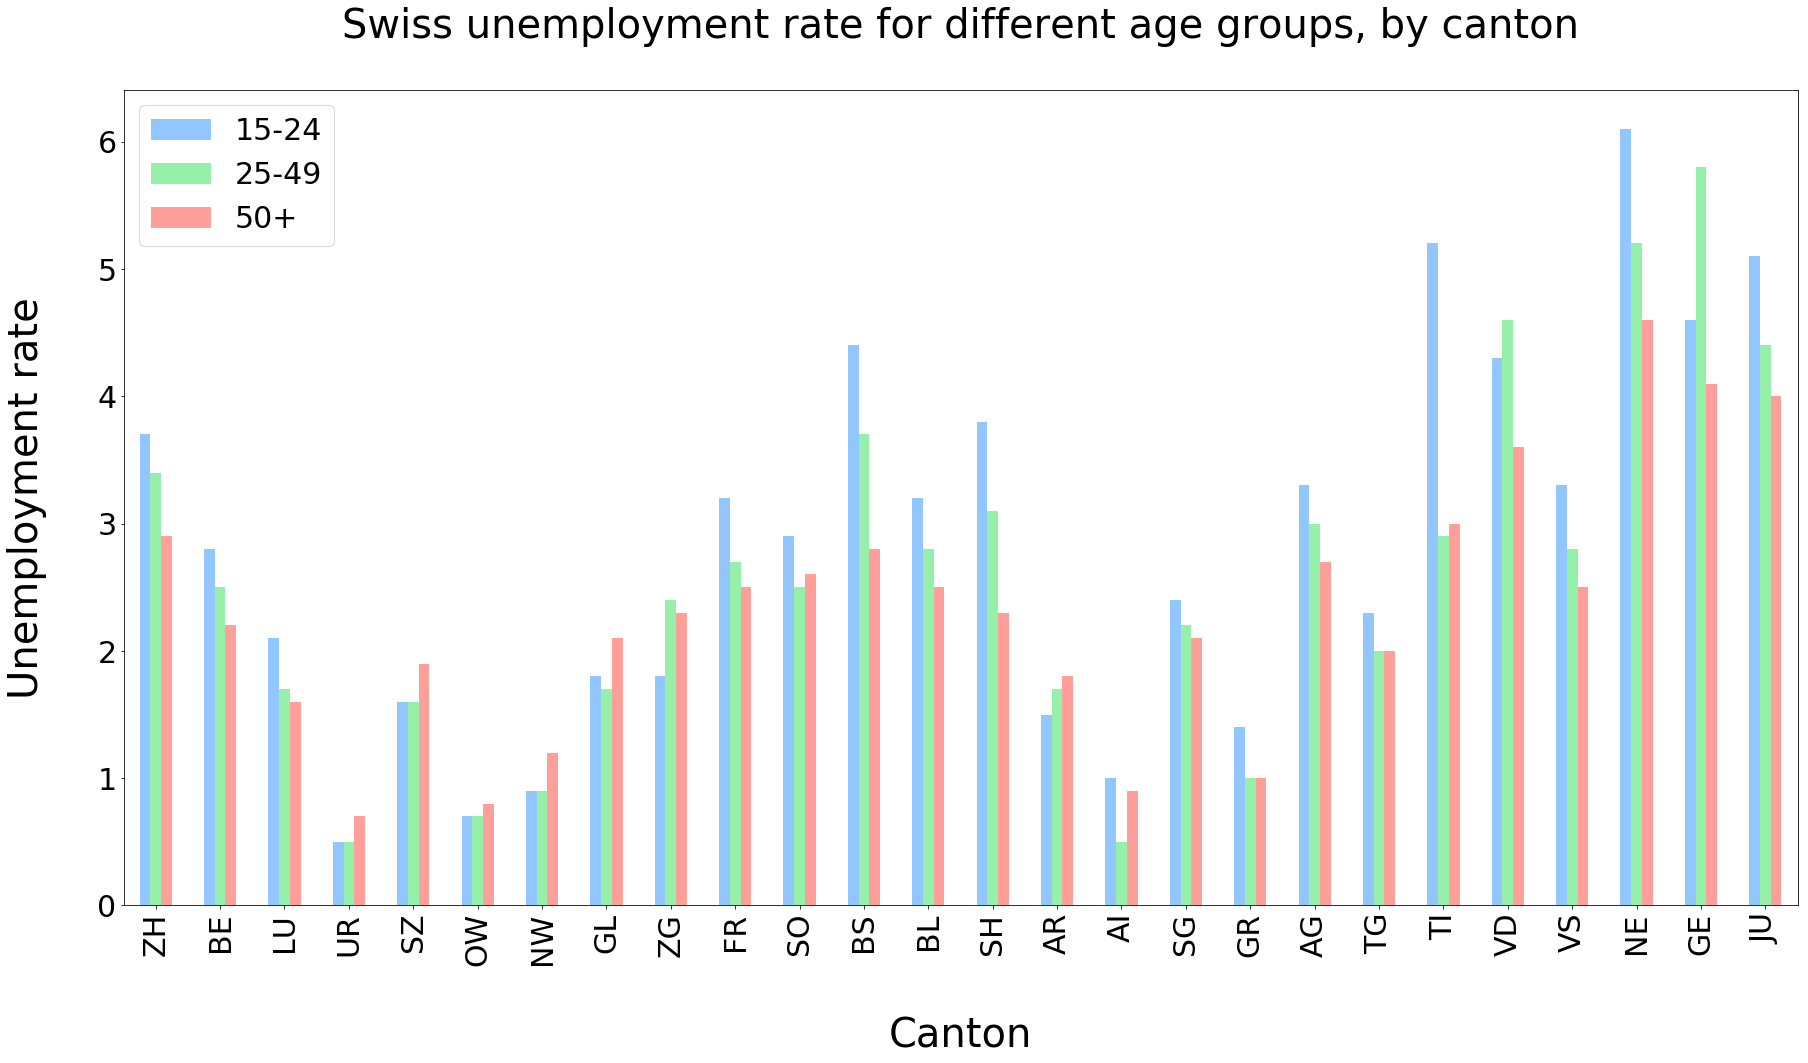

In [12]:
#define style for plt
plt.style.use('seaborn-pastel')

age_data = ch_total_unemployment_rate[['canton', '15_24', '25_49', '50_']]
age_data.plot.bar(x='canton', figsize=(30,15), fontsize=30)
plt.title('Swiss unemployment rate for different age groups, by canton\n', fontsize=40)
plt.xlabel('\nCanton', fontsize=40)
plt.ylabel('Unemployment rate\n', fontsize=40)
plt.legend(labels=['15-24', '25-49', '50+'], loc='upper left', prop={'size': 30})
plt.show()

We can see that for most cantons, there is not much difference of unemployment rate among the tree age classes. On the other hand for a few cantons, there is a lot of discrepancy.

For example in Tessin, we see that the young people are a lot more affected by the unemployment compared to the two other age categories. In fact, this is the canton with the largest difference between two classes of ages with a value greater than 2%.

In Geneva, the middle class is the one who struggles the most. Obwald has the smaller differences among the age classes.

Finally, for 60% of the cantons, we observe that for two age categories the older category as always a lower unemployment rate than the younger one.

## BONUS - Röstigraben

In [13]:
m = folium.Map([46.9182, 8.2275], tiles='cartodbpositron', zoom_start=8)

bins = pysal.Natural_Breaks(y=ch_total_unemployment_rate['röstigraben'], k=3).bins.tolist()

m.choropleth(
    geo_data=ch_topojson,
    data=ch_total_unemployment_rate,
    columns=['canton', 'röstigraben'],
    key_on='feature.id',
    topojson='objects.cantons',
    threshold_scale=bins,
    fill_color='OrRd',
    fill_opacity=0.75,
    line_opacity=1,
    line_weight=1.3,
    legend_name='Unemployed Rate (%)',
    smooth_factor=1.3)

m

In this map, the rate of unemployment is presented by the parts that characterize the Röstigraben. Notice that the Tessin has been set aside. For each of these regions, the mean of the different cantons composing it has been calculated.

We notice that the French-speaking part as a rate twice as high as the German-speaking part. This is a significant difference. The Tessin stands between the two.